# Single-site

author: steeve.laquitaine@epfl.ch; laquitainesteeve@gmail.com  

### Setup

Activate `spikebias` env kernel

In [50]:
# SETUP PACKAGESP
%load_ext autoreload
%autoreload 2
import os
from os.path import join
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
import yaml
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

# move to project path
proj_path = "/Users/steeve_laquitaine/Desktop/2022_2024_bbp/spikebias/"
os.chdir(proj_path)

# custom package
from src.nodes.utils import get_config
from src.nodes.validation import noise

# SETUP PARAMETERS
LAYER = "L5"
DURATION = 1.01
SF_V = 30000 # sampling frequency
SF_S = 40000
SF_B = 32000
SF_E = 20000
SF_dense = 20000
ID_PERIOD_SILI = 51  # 10, 7
ID_PERIOD_VIVO = 7
ID_PERIOD_B = 46  # period near argmax amplitude
ID_PERIOD_E = 6
L5_SITE_SILI = 0
L5_SITE_VIVO = 6
YLIM = (-100, 30)
SITE_B = 352  # 40  # site of argmax amplitude
SITE_E = 232

# in vivo (marques)
data_conf_vivo, param_conf_h_vivo = get_config("vivo_marques", "c26").values() 
PREP_PATH_vivo = data_conf_vivo["preprocessing"]["full"]["output"]["trace_file_path"]

# biophy model
cfg_ns, param_conf_sili = get_config("silico_neuropixels", "npx_spont").values()
PREP_PATH_ns = cfg_ns["preprocessing"]["full"]["output"]["trace_file_path"]

# synthetic (Buccino) 
data_conf_b, _ = get_config("buccino_2020", "2020").values()
PREP_PATH_b = data_conf_b["preprocessing"]["full"]["output"]["trace_file_path"]

# evoked biophy model
data_conf_e, param_conf_e = get_config("silico_neuropixels", "npx_evoked").values()
PREP_PATH_e = data_conf_e["preprocessing"]["full"]["output"]["trace_file_path"]

# Dense pobe
# vivo
data_conf_h_vivo, param_conf_h_vivo = get_config("vivo_horvath", "probe_2").values() 
PREP_PATH_h_vivo = data_conf_h_vivo["preprocessing"]["full"]["output"]["trace_file_path"]

# silico
data_conf_ds_sili, param_conf_ds_sili = get_config("dense_spont", "probe_2").values()
PREP_PATH_ds_sili = data_conf_ds_sili["preprocessing"]["full"]["output"]["trace_file_path"]

# figure parameters
SAVE_FIG = False
SAVE_FIG_DATA = False
LOAD_FIG_DATA = True

with open(join(proj_path, "conf/figures.yml"), "r", encoding="utf-8") as yaml_file:
    fig_data_paths = yaml.load(yaml_file, Loader=yaml.FullLoader)

# FIGURE SETTINGS
FIG_SIZE = (0.9, 0.7)

# colors
COLOR_MV = [0.6, 0.6, 0.6]
COLOR_MS = [0.9, 0.14, 0.15]
COLOR_B = [0.22, 0.5, 0.72]
COLOR_E = [1, 0.49, 0]
COLOR_HV = [0.3, 0.3, 0.3]
COLOR_HS = np.array([26, 152, 80]) / 255

# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6
plt.rcParams["lines.linewidth"] = 0.5
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 
plt.rcParams["xtick.minor.width"] = 0.5 
plt.rcParams["ytick.major.width"] = 0.5 
plt.rcParams["ytick.minor.width"] = 0.5
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1

# legend
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-12-17 18:45:54,347 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-17 18:45:54,410 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-12-17 18:45:54,411 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-17 18:45:54,468 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-12-17 18:45:54,470 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-17 18:45:54,505 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-12-17 18:45:54,508 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-17 18:45:54,598 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-12-17 18:45:54,601 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-17 18:45:54,629 - root - utils.py - get_config - INFO - R

### (.2s)Load voltage traces

In [33]:
if SAVE_FIG_DATA:
    
    # biophy model
    RecS = si.load_extractor(PREP_PATH_ns)
    RecS = RecS.frame_slice(start_frame=0, end_frame=10 * 60 * SF_S)
    traces_s = RecS.get_traces()

    # synthetic model
    RecB = si.load_extractor(PREP_PATH_b)
    traces_b = RecB.get_traces()

    # evoked biophy model
    RecE = si.load_extractor(PREP_PATH_e)
    traces_e = RecE.get_traces()

### Marques-Smith

In [34]:
# get data
if SAVE_FIG_DATA:
    
    # get voltage traces
    Recording_vivo = si.load_extractor(PREP_PATH_vivo)
    traces_vivo = Recording_vivo.get_traces()

    # get a site in layer 5
    layers_vivo = Recording_vivo.get_property("layers")
    L5_site_vivo = np.where(layers_vivo == LAYER)[0][L5_SITE_VIVO]

    # calculate one seconde period
    one_sec_period = np.arange((ID_PERIOD_VIVO - 1) * SF_V, ID_PERIOD_VIVO * SF_V, 1)

    # plot figure
    fig_data = traces_vivo[one_sec_period, L5_site_vivo]

    # save figure data
    np.save(fig_data_paths["fig2a_compo_vivo_npx"], fig_data)
    
elif LOAD_FIG_DATA:
    fig_data = np.load(join(proj_path, fig_data_paths["fig2a_compo_vivo_npx"]))
    print("loaded figure data")

loaded figure data


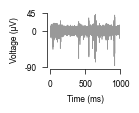

In [35]:
# plot
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

# plot figure
ax.plot(fig_data, color=COLOR_MV)

# legend
ax.spines[["right", "top"]].set_visible(False)
ax.set_ylabel("Voltage (\u03bcV)")
ax.set_xlabel("Time (ms)")
ax.set_yticks([-90, 0, 45], [-90, 0, 45])
ax.set_ylim([-90, 45])
ax.set_xticks([0, SF_V / 2, SF_V], [0, 500, 1000])
ax.set_xlim([0, SF_V])

# disconnected
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

# save figure
if SAVE_FIG:
    plt.savefig("figures/0_validation/1_components/fig2a_compo_vivo_npx.svg")
    

In [36]:
# get data

# background noise (min(MAD) over segments of 1 sec) here
if SAVE_FIG_DATA:
    wind_end = int(np.floor(len(traces_vivo)/SF_V))
    bkg_noise = noise.measure_trace_noise(traces_vivo[one_sec_period, L5_site_vivo], SF_V, wind_end)
    np.save(fig_data_paths["fig2a_compo_vivo_npx_bkg_noise"], bkg_noise)
elif LOAD_FIG_DATA:
    bkg_noise = np.load(fig_data_paths["fig2a_compo_vivo_npx_bkg_noise"])
    print("loaded figure data")
    
print("nb of 1-sec windows:", len(bkg_noise))
print("Background noise level (min MAD over windows):", min(bkg_noise))

loaded figure data
nb of 1-sec windows: 1215
Background noise level (min MAD over windows): 3.7754414


### NS

* plot trace from site 143 in layer 5
* we will plot the same trace from site 143 in layer 5, same as for the evoked model, but locked to the stimulus.

In [37]:
# get data
if SAVE_FIG_DATA:
        
    ID_PERIOD_SILI = 10 #9, 6 4, 2  # 10, 7

    # get a site in layer 5
    SITE_IX = 21
    layers_s = RecS.get_property("layers")
    L5_site = np.where(layers_s == LAYER)[0][SITE_IX]
    print("Sites in layer 5:", L5_site)

    # calculate one seconds period
    one_sec_period = np.arange((ID_PERIOD_SILI - 1) * SF_S, ID_PERIOD_SILI * SF_S, 1)
    
    # get figure data
    fig_data = traces_s[one_sec_period, L5_site]

    # save figure data
    np.save(fig_data_paths["fig2b_compo_silico_npx"], fig_data)
elif LOAD_FIG_DATA:
    fig_data = np.load(fig_data_paths["fig2b_compo_silico_npx"])
    print("loaded figure data")

loaded figure data


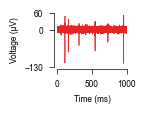

In [38]:
# plot
YMAX = 60
YMIN = -130
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

# plot figure
ax.plot(fig_data, color=COLOR_MS)

# legend
ax.spines[["right", "top"]].set_visible(False)
ax.set_ylabel("Voltage (\u03bcV)")
ax.set_xlabel("Time (ms)")
plt.xticks([0, SF_S / 2, SF_S])
ax.set_xticklabels([0, 500, 1000])
ax.set_xlim([0, SF_S])

# disconnected
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))
ax.set_yticks([YMIN, 0, YMAX])
ax.set_ylim([YMIN, YMAX])

# save
if SAVE_FIG:
    plt.savefig("figures/0_validation/1_components/fig2b_compo_silico_npx.svg")

In [39]:
# get data
# print background noise (min(MAD) over segments of 1 sec) here
if SAVE_FIG_DATA:
    wind_end = int(np.floor(len(traces_s)/SF_S))
    bkg_noise = noise.measure_trace_noise(traces_s[one_sec_period, L5_site], SF_S, wind_end)
    np.save(fig_data_paths["fig2b_compo_silico_npx_bkg_noise"], bkg_noise)
elif LOAD_FIG_DATA:
    bkg_noise = np.load(fig_data_paths["fig2b_compo_silico_npx_bkg_noise"])    
    print("loaded figure data")
    
print("nb of 1-sec windows:", len(bkg_noise))
print("Background noise level (min MAD over windows):", min(bkg_noise))

loaded figure data
nb of 1-sec windows: 600
Background noise level (min MAD over windows): 3.239969


### Evoked biophysical model 

* from stimulus start (STIM_START= 20110000 at the 5000th stimulus epoch, t=0 ms) to 1000 ms after.
* plot trace from site 143 in layer 5, same as for the spontaneous model.

In [40]:
if SAVE_FIG_DATA: 
    # set sample start at stimulus start (5000th epoch)
    STIM_START = 20110000
    SITE_IX = 21

    layers_e = RecE.get_property("layers")
    L5_site = np.where(layers_e == LAYER)[0][SITE_IX]
    print("Sites in layer 5:", L5_site)
    print("Identified stimulus sample index:", STIM_START)

    # calculate one second period
    one_sec_period = np.arange(STIM_START, STIM_START + SF_E, 1)

    # get figure data
    fig_data = traces_e[one_sec_period, L5_site]
    
    # save figure data
    np.save(fig_data_paths["fig2c_compo_evoked_npx"], fig_data)
elif LOAD_FIG_DATA: 
    fig_data = np.load(fig_data_paths["fig2c_compo_evoked_npx"])
    print("loaded figure data")

loaded figure data


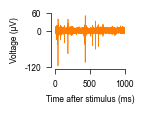

In [41]:
# plot
YMAX = 60
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

# plot figure
ax.plot(fig_data, color=COLOR_E)  # 21, 25, 40, 38

# legend
ax.spines[["right", "top"]].set_visible(False)
ax.set_ylabel("Voltage (\u03bcV)")
ax.set_xlabel("Time after stimulus (ms)")
ax.set_yticks([-120, 0, YMAX], [-120, 0, YMAX])
ax.set_ylim([-120, YMAX])
ax.set_xticks([0, SF_E / 2, SF_E], [0, 500, 1000])
ax.set_xlim([0, SF_E])

# disconnected
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

# save
if SAVE_FIG:
    plt.savefig("figures/0_validation/1_components/fig2c_compo_evoked_npx.svg")

In [42]:
# print background noise (min(MAD) over segments of 1 sec) here
if SAVE_FIG_DATA:
    wind_end = int(np.floor(len(traces_e)/SF_E))
    bkg_noise = noise.measure_trace_noise(traces_e[one_sec_period, L5_site], SF_E, wind_end)
    np.save(fig_data_paths["fig2c_compo_evoked_npx_bkg_noise"], fig_data)
elif LOAD_FIG_DATA:
    bkg_noise=np.load(fig_data_paths["fig2c_compo_evoked_npx_bkg_noise"])
    print("loaded figure data")
    
print("nb of 1-sec windows:", len(bkg_noise))
print("Background noise level (min MAD over windows):", min(bkg_noise))

loaded figure data
nb of 1-sec windows: 20000
Background noise level (min MAD over windows): -118


### Synthetic model (Buccino)

In [47]:
if SAVE_FIG_DATA: 
    ID_PERIOD_B = 43  # period near argmax amplitude
    # calculate one seconde period
    one_sec_period = np.arange((ID_PERIOD_B - 1) * SF_B, ID_PERIOD_B * SF_B, 1)
    # get figure data
    fig_data = traces_b[one_sec_period, SITE_B]
    # save
    np.save(fig_data_paths["fig2d_compo_synth_npx"], fig_data)
elif LOAD_FIG_DATA:
    fig_data = np.load(fig_data_paths["fig2d_compo_synth_npx"])
    print("loaded figure data")

loaded figure data


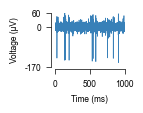

In [48]:
# plot
YMAX = 60
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

# plot figure
ax.plot(fig_data, color=COLOR_B)

# legend
ax.spines[["right", "top"]].set_visible(False)
ax.set_ylabel("Voltage (\u03bcV)")
ax.set_xlabel("Time (ms)")
ax.set_yticks([-170, 0, YMAX], [-170, 0, YMAX])
ax.set_ylim([-170, YMAX])
ax.set_xticks([0, SF_B / 2, SF_B], [0, 500, 1000])
ax.set_xlim([0, SF_B])

# disconnected
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

# save
if SAVE_FIG:
    plt.savefig("figures/0_validation/1_components/fig2d_compo_synth_npx.svg")

In [49]:
# print background noise (min(MAD) over segments of 1 sec) here
if SAVE_FIG_DATA:
    wind_end = int(np.floor(len(traces_b)/SF_B))
    bkg_noise = noise.measure_trace_noise(traces_b[one_sec_period, SITE_B], SF_B, wind_end)
    np.save(fig_data_paths["fig2d_compo_synth_npx_bkg_noise"], bkg_noise)
elif LOAD_FIG_DATA: 
    bkg_noise = np.load(fig_data_paths["fig2d_compo_synth_npx_bkg_noise"])
    print("loaded figure data")    
    
print("nb of 1-sec windows:", len(bkg_noise))
print("Background noise level (min MAD over windows):", min(bkg_noise))

loaded figure data
nb of 1-sec windows: 600
Background noise level (min MAD over windows): 5.8605204


# DENSE probe

In [51]:
if SAVE_FIG_DATA:
    
    # load Recording
    Recording_sili = si.load_extractor(PREP_PATH_ds_sili)
    traces_sili = Recording_sili.get_traces()

    # get a site in layer 5
    layers_sili = Recording_sili.get_property("layers")

In [52]:
# get data
if SAVE_FIG_DATA:
    
    # plot
    ID_PERIOD_SILI = 10 #20  # 15  # 31, 18, 50  # 50, 7
    L5_SITE_SILI = 10  # 10, 1, 5

    # set period
    # get trace
    L5_site = np.where(layers_sili == LAYER)[0][L5_SITE_SILI]

    # calculate one seconde period
    one_sec_period = np.arange(
        (ID_PERIOD_SILI - 1) * SF_dense, ID_PERIOD_SILI * SF_dense, 1
    )
    # save figure data
    fig_data = traces_sili[one_sec_period, L5_site]    
    np.save(fig_data_paths["fig2d_compo_silico_horv"], fig_data)
    
elif LOAD_FIG_DATA:
    fig_data = np.load(join(proj_path, fig_data_paths["fig2d_compo_silico_horv"]))
    print("loaded figure data")

loaded figure data


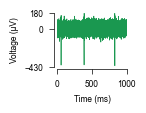

In [54]:
# plot
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
ax.plot(fig_data, color=COLOR_HS)

# legend
ax.spines[["right", "top"]].set_visible(False)
ax.set_ylabel("Voltage (\u03bcV)")
ax.set_xlabel("Time (ms)")
ax.set_xticks([0, SF_dense / 2, SF_dense], [0, 500, 1000])
ax.set_xlim([0, SF_dense])
ax.set_yticks([-430, 0, 180])
ax.set_ylim([-430, 180])

# disconnected
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

# save figure
if SAVE_FIG:
    plt.savefig("figures/0_validation/1_components/fig2d_compo_silico_horv.svg")

In [55]:
# get data

# background noise (min(MAD) over segments of 1 sec) here
if SAVE_FIG_DATA:
    wind_end = int(np.floor(len(traces_sili)/SF_dense))
    bkg_noise = noise.measure_trace_noise(traces_sili[one_sec_period, L5_site], SF_dense, wind_end)
    np.save(fig_data_paths["fig2d_compo_silico_horv_bkg_noise"], bkg_noise)
elif LOAD_FIG_DATA:
    bkg_noise = np.load(fig_data_paths["fig2d_compo_silico_horv_bkg_noise"])
    print("loaded figure data")
    
print("nb of 1-sec windows:", len(bkg_noise))
print("Background noise level (min MAD over windows):", min(bkg_noise))

loaded figure data
nb of 1-sec windows: 1175
Background noise level (min MAD over windows): 29.4982


## Vivo

In [56]:
if SAVE_FIG_DATA:
    # plot
    ## to find max
    # L5_site_vivo = np.where(layers_vivo == LAYER)[0]
    # x = traces_vivo[:, L5_site_vivo]
    # ind = np.unravel_index(np.argmax(x, axis=None), x.shape)
    L5_SITE = 79  # 24  # 1
    SAMPLE_START = 15868410

    # get traces
    Recording_vivo = si.load_extractor(PREP_PATH_h_vivo)
    traces_vivo = Recording_vivo.get_traces()

    # get a site in layer 5
    layers_vivo = Recording_vivo.get_property("layers")
    L5_site_vivo = np.where(layers_vivo == LAYER)[0][L5_SITE]

    # calculate one seconde period
    one_sec_period = np.arange(SAMPLE_START, SAMPLE_START + SF_dense, 1)
    
    # save figure data
    fig_data = traces_vivo[one_sec_period, L5_site_vivo]
    np.save(fig_data_paths["fig2e_compo_vivo_horv"], fig_data)

elif LOAD_FIG_DATA:
    fig_data = np.load(join(proj_path, fig_data_paths["fig2e_compo_vivo_horv"]))
    print("loaded figure data")

loaded figure data


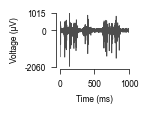

In [57]:
# plot
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

ax.plot(fig_data, color=COLOR_HV)

# legend
ax.spines[["right", "top"]].set_visible(False)
ax.set_ylabel("Voltage (\u03bcV)")
ax.set_xlabel("Time (ms)")
ax.set_xticks([0, SF_dense / 2, SF_dense], [0, 500, 1000])
ax.set_xlim([0, SF_dense])
ax.set_yticks([-2060, 0, 1015], [-2060, 0, 1015])
ax.set_ylim([-2060, 1015])

# disconnected
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

# save
if SAVE_FIG:
    plt.savefig("figures/0_validation/1_components/fig2e_compo_vivo_horv.svg")